# Demonstration of PyMC Markov Chain Monte Carlo  on a Nonlinear Model with 4 Parameters

In [36]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pandas as pd

# Configuration
np.random.seed(42)
param_names = ["m0", "m1", "m2", "m3"]
model_string = "y = m0 / (1 + exp(-m1*(x - m2))) + m3*sin(x)"
true_params = [3.0, 2.0, 5.0, 0.2]

def nonlinear_model(x, m):
    return m[0] / (1 + np.exp(-m[1]*(x - m[2]))) + m[3] * np.sin(x)

# Simulated observations
sigma_low = 0.0005
sigma_high = 10.0

x_data = np.linspace(0, 10, 800)
y_true = nonlinear_model(x_data, true_params)
y_obs_low = y_true + np.random.normal(0, sigma_low, size=len(x_data))
y_obs_high = y_true + np.random.normal(0, sigma_high, size=len(x_data))

# pyMC parameters
target_accept = 0.9 
max_treedepth = 12
draws = 1000 
tune = 1000

In [37]:
def run_pymc_sampling(x, y_obs, sigma, target_accept=0.8, max_treedepth=10, draws=1000, tune=1000):
    with pm.Model() as model:
        m0 = pm.Normal("m0", mu=1, sigma=2)
        m1 = pm.Normal("m1", mu=1, sigma=2)
        m2 = pm.Normal("m2", mu=5, sigma=2)
        m3 = pm.Normal("m3", mu=0, sigma=1)
        y_model = m0 / (1 + pm.math.exp(-m1*(x - m2))) + m3 * pm.math.sin(x)
        y_obs_ = pm.Normal("y_obs", mu=y_model, sigma=sigma, observed=y_obs)

        trace = pm.sample(draws=draws, tune=tune, target_accept=target_accept,
                          max_treedepth=max_treedepth, return_inferencedata=True, random_seed=42)
    return trace

In [38]:
def plot_fits(x, y_true, y_obs, mean_params, label):
    plt.figure(figsize=(10, 4))
    plt.plot(x, y_true, 'k-', label='True')
    plt.plot(x, y_obs, '.', label='Observed', alpha=0.4)
    plt.plot(x, nonlinear_model(x, mean_params), 'r--', label='Inferred')
    plt.title(f'{label} Fit')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def triangle_plot(data, param_names, true_params, inferred_params, label):
    if  isinstance(data, np.ndarray):
        df = pd.DataFrame(data, columns=param_names)
    else:
        df = az.extract(data, var_names=param_names).to_dataframe()[param_names]
    
    g = sns.PairGrid(df, vars=param_names, corner=True)
    g.map_lower(sns.kdeplot, levels=5, fill=False)
    g.map_diag(sns.kdeplot, fill=True)
    for i, p in enumerate(param_names):
        ax = g.axes[i, i]
        ax.axvline(true_params[i], color='k', linestyle='-')
        ax.axvline(inferred_params[i], color='r', linestyle='--')

    plt.suptitle(label + " - Triangle Plot", y=1.02)
    plt.show()
    
def print_summary(model_string, true_vals, inferred_vals, label):
    print(f"--- {label} Summary ---")
    print(f"{model_string}")

    print(f"{'Param':<5} {'True':>10} {'Inferred':>10} {'Error':>10}")
    for name, t, p in zip(param_names, true_vals, inferred_vals):
        print(f"{name:<5} {t:10.4f} {p:10.4f} {p - t:10.4f}")

## 🔵 Inference on Low Noise Data (σ = 0.01)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m0, m1, m2, m3]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


--- Low Noise Summary ---
y = m0 / (1 + exp(-m1*(x - m2))) + m3*sin(x)
Param       True   Inferred      Error
m0        3.0000     3.0000     0.0000
m1        2.0000     2.0000     0.0000
m2        5.0000     5.0000     0.0000
m3        0.2000     0.2000     0.0000


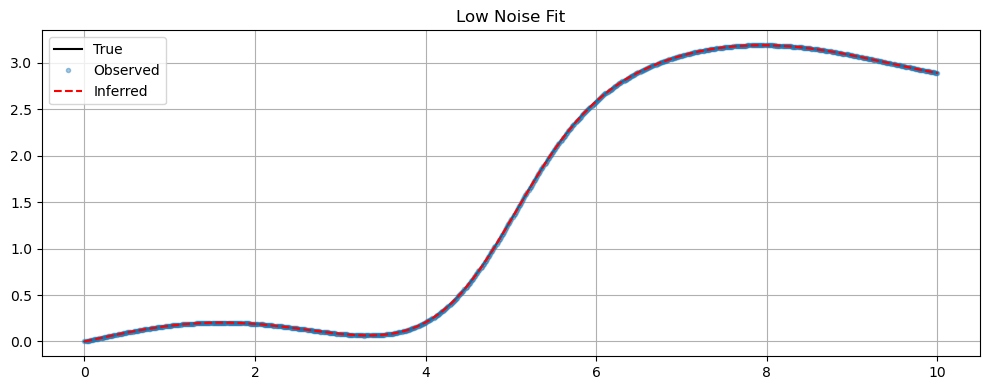

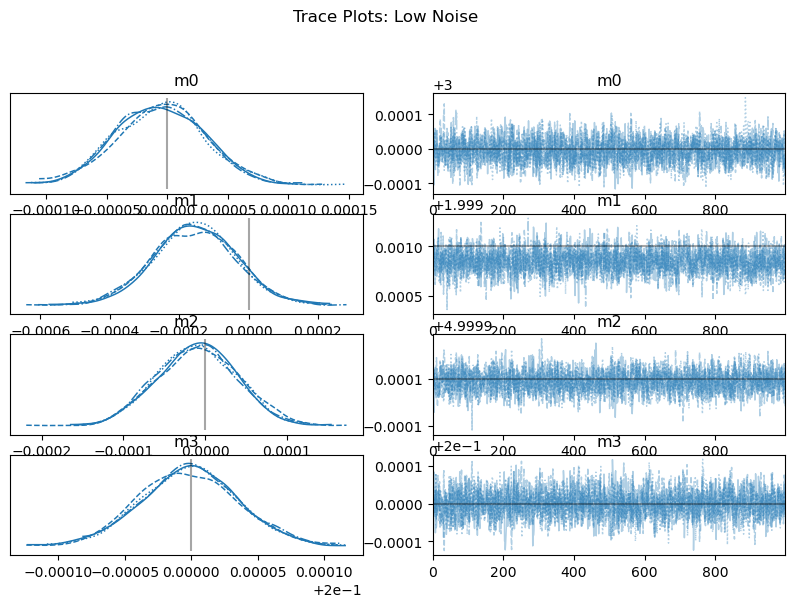

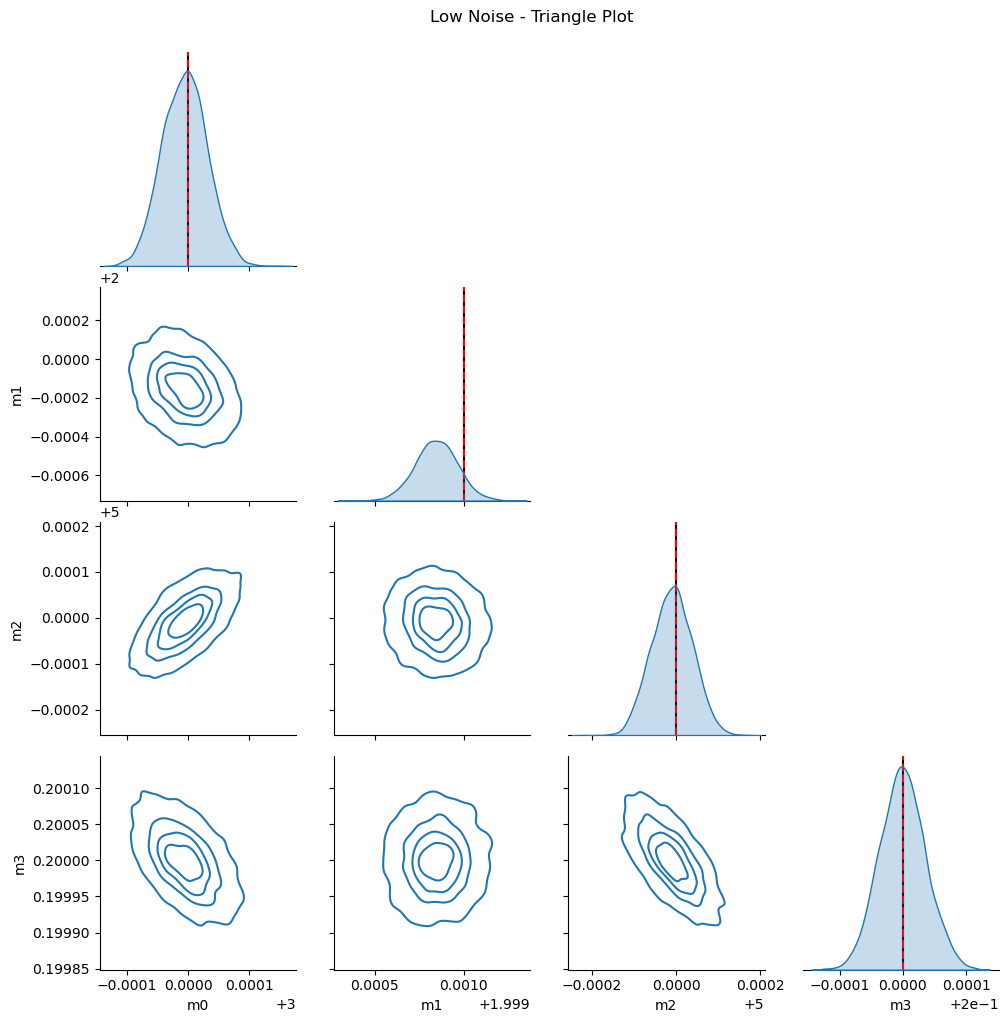

In [39]:
idata_low = run_pymc_sampling(x_data, y_obs_low, sigma_low, target_accept, max_treedepth, draws, tune)
mean_low = az.summary(idata_low, var_names=param_names)['mean'].values

print_summary(model_string, true_params, mean_low, "Low Noise")
plot_fits(x_data, y_true, y_obs_low, mean_low, "Low Noise")
az.plot_trace(idata_low, var_names=param_names, figsize=(10, 6), lines=[(k, {}, [v]) for k, v in zip(param_names, true_params)])
plt.suptitle("Trace Plots: Low Noise", y=1.02)
plt.show()

triangle_plot(idata_low, param_names, true_params, mean_low, "Low Noise")

## 🔴 Inference on High Noise Data (σ = 2.0)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m0, m1, m2, m3]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


--- High Noise Summary ---
y = m0 / (1 + exp(-m1*(x - m2))) + m3*sin(x)
Param       True   Inferred      Error
m0        3.0000     3.0450     0.0450
m1        2.0000     1.7960    -0.2040
m2        5.0000     3.4660    -1.5340
m3        0.2000     1.2390     1.0390


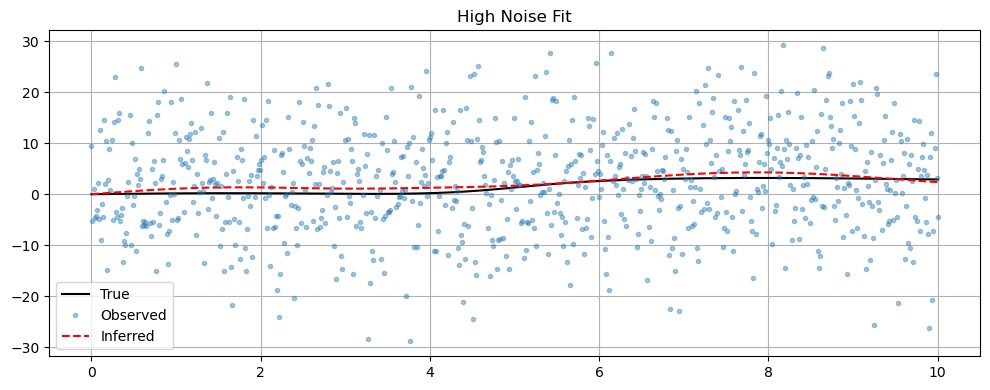

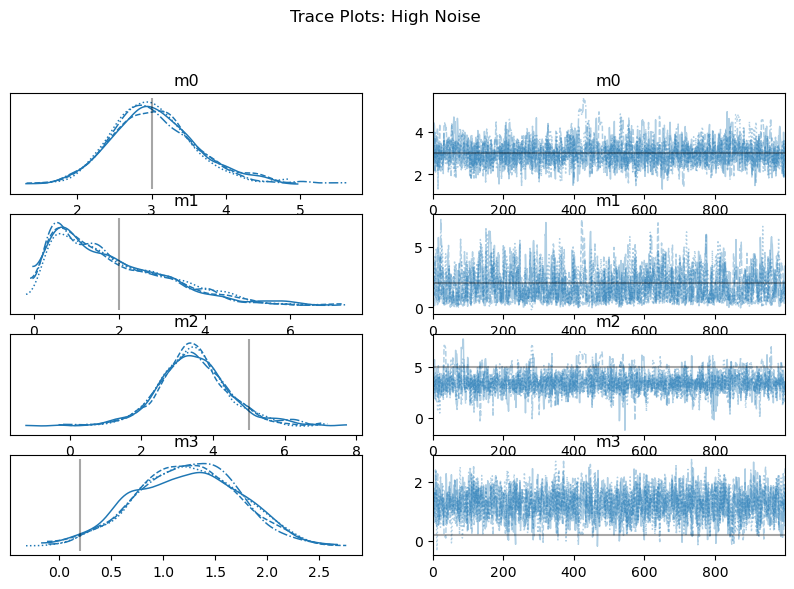

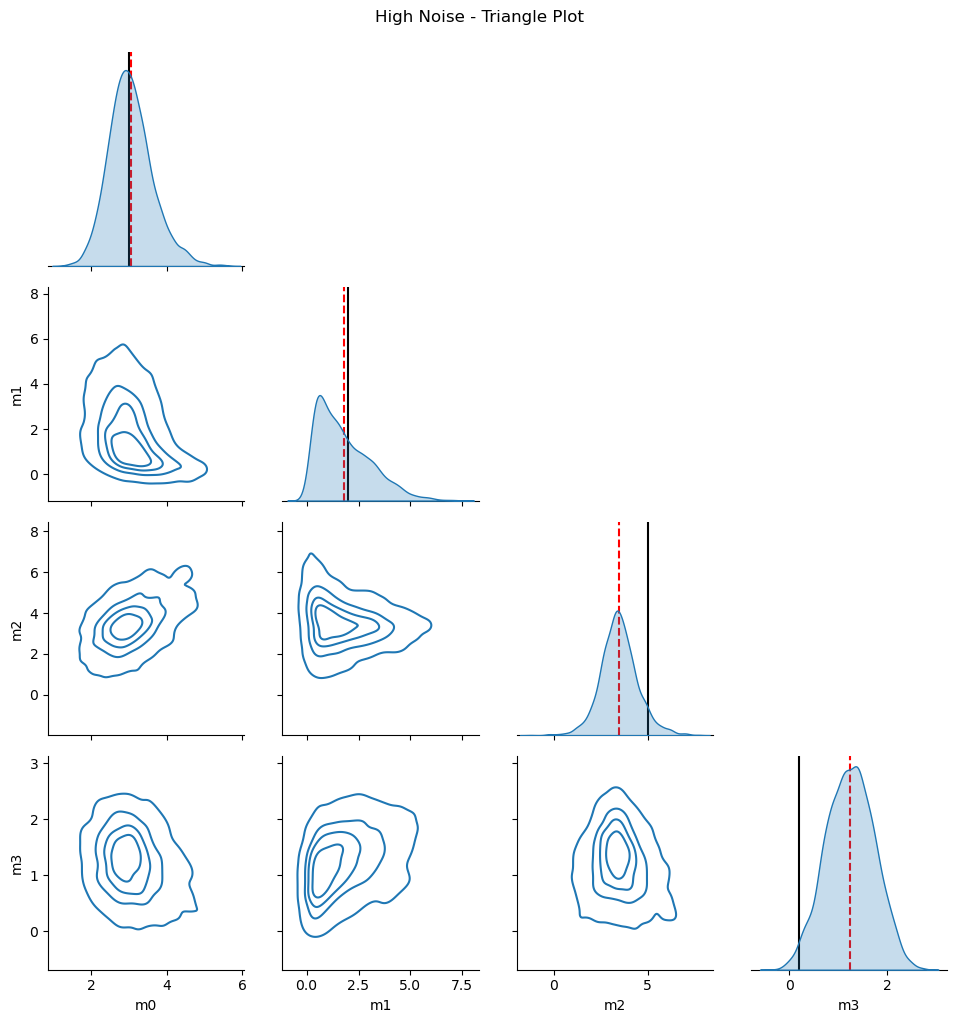

In [40]:
idata_high = run_pymc_sampling(x_data, y_obs_high, sigma_high, target_accept, max_treedepth, draws, tune)
mean_high = az.summary(idata_high, var_names=param_names)['mean'].values

print_summary(model_string, true_params, mean_high, "High Noise")
plot_fits(x_data, y_true, y_obs_high, mean_high, "High Noise")
az.plot_trace(idata_high, var_names=param_names, figsize=(10, 6), lines=[(k, {}, [v]) for k, v in zip(param_names, true_params)])
plt.suptitle("Trace Plots: High Noise", y=1.02)
plt.show()

triangle_plot(idata_high, param_names, true_params, mean_high, "High Noise")
